In [ ]:
'''
This script contains Monte-Carlo, differential evolution and basin hopping for track fitting.
Each fitting methods works on two different objective functions, one implemented in the pytpc software and another 
chi-squared based function implemented by Christina Chen.
'''

In [1]:
# Imports
import numpy as np
import pytpc
import matplotlib.pyplot as plt
from pytpc.fitting.mcopt_wrapper import Tracker, EventGenerator, PadPlane, Minimizer
from pytpc.fitting.montecarlo import MCFitter
from pytpc.constants import *
from pytpc.cleaning import HoughCleaner
import pandas as pd
import matplotlib.pyplot as plt
import h5py
import yaml
import math
from effsim.paramgen import uniform_param_generator
from effsim.effsim import EventSimulator
from scipy import interpolate
from math import sqrt
from pytpc.utilities import rot_matrix

/home/chen/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
with open('/home/chen/ar40/config/config_e15503a_runs_92-104.yml', 'r') as f:
    config = yaml.load(f)

mcfitter = MCFitter(config)

In [3]:
num_iters = config['num_iters']
num_pts = config['num_pts']
red_factor = config['red_factor']
pad_rot_angle = (config['pad_rot_angle']*math.pi)/180

In [48]:
#Good events for run_0102 are: 689, 765, 896, 305, 504, 575, 456, 299, 399, 156, 231, 7832, 1568, 1354, 789, 485, 2456, 357, 4568, 1448, 3578, 745, 430, 1676, 811, 641, 871, 785, 37, 24, 75, 72, 35, 16, 12, 1718, 1, 9
full = h5py.File('/home/chen/ar40/config/clean_run_0102.h5', 'r')
evt_ID = 305
dataset_name = '/clean'
evt_full = full[dataset_name]
xyzs_h5 = evt_full[str(evt_ID)]
xyzs = np.array(xyzs_h5)

#data cleaning
del_list = []

DRIFT_VEL = 5.2
CLOCK = 12.5

for i in range(len(xyzs)):
    if (xyzs[i,6]) > 300.0: #delete the points which are more than 300mm away from the center of the spiral
        del_list.append(i)
    elif (xyzs[i][2])*CLOCK/DRIFT_VEL > 500.0: #delete points that have time bucket index less than 500
        del_list.append(i)
    elif (xyzs[i][5] < 2.0): #delete the points that have more than two neighbors within radius of 15mm
        del_list.append(i)         

cut_xyzs = np.delete(xyzs,del_list,axis=0)

print(xyzs[0])

[-1.45741499e+02  9.06868891e-01  1.86516085e+02  5.14131784e+02
  9.18200000e+03  4.00000000e+00  1.47813910e+01]


In [49]:
#finding center of curvature (original data)
xy = xyzs[:, 0:2]
xy_C = np.ascontiguousarray(xy, dtype=np.double)
cx, cy = pytpc.cleaning.hough_circle(xy_C)
print(cx,cy) #The center of curvature of the track, in mm.

#finding center of curvature (cleaned data)
cut_xy = cut_xyzs[:, 0:2]
cut_xy_C = np.ascontiguousarray(cut_xy, dtype=np.double)
cut_cx, cut_cy = pytpc.cleaning.hough_circle(cut_xy_C)

-43.91625428724363 9.816445862844423


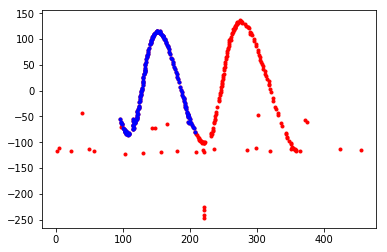

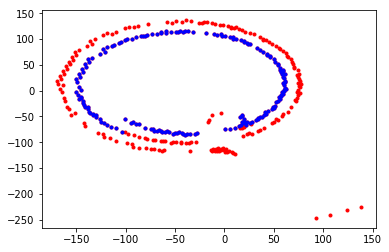

In [50]:
#plotting real event
%matplotlib inline
plt.plot(xyzs[:, 2], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 2], cut_xyzs[:, 1], 'b.')
plt.show()
plt.plot(xyzs[:, 0], xyzs[:, 1], 'r.')
plt.plot(cut_xyzs[:, 0], cut_xyzs[:, 1], 'b.')
plt.show()

In [22]:
#transform data into uvw coordinates
uvw, (cu, cv) = mcfitter.preprocess(xyzs[:,0:5], center=(cx, cy), rotate_pads=False)
uvw_values = uvw.values #transform pd file to arrays
uvw_sorted = uvw.sort_values(by='w', ascending=True)
prefit_data = uvw_sorted.iloc[-len(uvw_sorted) // 4:].copy()
prefit_res = mcfitter.linear_prefit(prefit_data, cu, cv)
#find seed point for Monte-Carlo
ctr0 = mcfitter.guess_parameters(prefit_res)

cut_uvw, (cut_cu, cut_cv) = mcfitter.preprocess(cut_xyzs[:,0:5], center=(cut_cx, cut_cy), rotate_pads=False)
cut_uvw_sorted = cut_uvw.sort_values(by='w', ascending=True)
cut_prefit_data = cut_uvw_sorted.iloc[-len(cut_uvw_sorted) // 4:].copy()
cut_prefit_res = mcfitter.linear_prefit(cut_prefit_data, cut_cu, cut_cv)
cut_ctr0 = mcfitter.guess_parameters(cut_prefit_res)

[ 0.          0.          0.43940586  1.46760508 -2.7894479   1.90697197]


In [23]:
#calculate experimental hit pattern
exp_hits = np.zeros(10240)
for a, p in uvw[['a', 'pad']].values:
    exp_hits[int(p)] = a
    
cut_exp_hits = np.zeros(10240)
for a, p in cut_uvw[['a', 'pad']].values:
    cut_exp_hits[int(p)] = a

In [24]:
sig = config['sigma']
# get initial parameter space
sigma_init = np.array([sig['x'],sig['y'],sig['z'],sig['enu'],sig['azi']*degrees,sig['pol']*degrees])

In [25]:
min_chi_value = []
min_chi_list = [sigma_init]
# set original candidate to be the seed point
candidate = ctr0

for i in range(num_iters): ### number of iteration equals 20
    
    # search space gets narrower within each iteration
    sigma = sigma_init*red_factor**float(i)
    
    # generate a set of parameter vectors within given range
    x = np.random.uniform(low=candidate[0]-sigma[0], high=candidate[0]+sigma[0], size=1000)
    y = np.random.uniform(low=candidate[1]-sigma[1], high=candidate[1]+sigma[1], size=1000)
    z = np.random.uniform(low=candidate[2]-sigma[2], high=candidate[2]+sigma[2], size=1000)
    # set min energy equal to zero
    if candidate[3]-sigma[3] >= 0.0:
        e = np.random.uniform(low=candidate[3]-sigma[3], high=candidate[3]+sigma[3], size=1000)
    else:
        e = np.random.uniform(low=0.0, high=candidate[3]+sigma[3], size=1000)
    a = np.random.uniform(low=candidate[4]-sigma[4], high=candidate[4]+sigma[4], size=1000)
    p = np.random.uniform(low=candidate[5]-sigma[5], high=candidate[5]+sigma[5], size=1000)

    candidates = np.stack((x,y,z,e,a,p),axis=-1)
    
    ##### define variables #####
    sigmaPos = 5.0 ### in mm
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sigmaEng = 0.1
    sim = EventSimulator(config)
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    chi2En_per_evt = 0.0
    
    count = 0
    num = 0
        
    while num-count <= num_pts-1.0: # make sure each iteration 500 candidates are generated

        chi2Pos_x = np.empty((0,0))
        chi2Pos_y = np.empty((0,0))

        try:
            evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2],\
                                       candidates[num][3], candidates[num][4], candidates[num][5])
        except Exception:
            count += 1
            num += 1
            continue
        
        #transform simulated data into uvw coordinates
        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
        sim_xy = sim_xyzs[:, 0:2]
        sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
        sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
        sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
        sim_uvw_values = sim_uvw.values
        
        ##### find energy chi2 #####

        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()

        sigmaEn = np.nanmax(exp_hits)*sigmaEng

        for p in range(10240):        
            if exp_hits[p] != 0:
                if np.isnan(exp_hits[p]) == False:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)

        ##### find Vertex chi2 #####

        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        ##### find position chi2 #####

        f_x = interpolate.interp1d(sim_uvw_values[:,7],sim_uvw_values[:,5],bounds_error=False)
        f_y = interpolate.interp1d(sim_uvw_values[:,7],sim_uvw_values[:,6],bounds_error=False)

        sim_x = f_x(uvw_values[:,7])
        sim_y = f_y(uvw_values[:,7])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x))
        sim_x[inds_x] = 0.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y))
        sim_y[inds_y] = 0.0

        chi2Pos_x = np.append(chi2Pos_x,(sim_x-uvw_values[:,5])/float(sigmaPos))    
        chi2Pos_y = np.append(chi2Pos_y,(sim_y-uvw_values[:,6])/float(sigmaPos)) 
        
        Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(uvw_values)))
        
        hit_num = 0.0
        Chi2Vert_per_evt = 0.0
        chi2En_per_evt = 0.0
        
        num += 1
        
    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    print(len(Poschi2))
    for i in range(len(Poschi2)):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 0.01:
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)
            print(min_chi_list)
            print(min_chi_value)

print(min_chi_value)
print(min_chi_list)
min_chi_list = np.delete(min_chi_list,0,0)
for i in range(len(min_chi_value)):
    if abs(min_chi_value[i]-min(min_chi_value)) < 0.01:
        print(min_chi_list[i])

[0.1        0.1        0.1        4.         1.04719755 0.52359878]


/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice


minimum chi2:174.74632062454666
500
[[ 0.1         0.1         0.1         4.          1.04719755  0.52359878]
 [ 0.03544293 -0.0105423   0.76885185  2.50109557 -3.0048499   2.0087546 ]]
[174.74632062454666]
[0.08       0.08       0.08       3.2        0.83775804 0.41887902]
minimum chi2:81.76913852781455
500
[[ 0.1         0.1         0.1         4.          1.04719755  0.52359878]
 [ 0.03544293 -0.0105423   0.76885185  2.50109557 -3.0048499   2.0087546 ]
 [-0.01170415 -0.01361708  0.73272711  3.50670618 -2.96792028  1.87497855]]
[174.74632062454666, 81.76913852781455]
[0.064      0.064      0.064      2.56       0.67020643 0.33510322]
minimum chi2:194.84884041579596
500
[[ 0.1         0.1         0.1         4.          1.04719755  0.52359878]
 [ 0.03544293 -0.0105423   0.76885185  2.50109557 -3.0048499   2.0087546 ]
 [-0.01170415 -0.01361708  0.73272711  3.50670618 -2.96792028  1.87497855]
 [ 0.05160059 -0.01779351  0.7578836   2.65500711 -2.94886196  1.96635508]]
[174.7463206245466

KeyboardInterrupt: 

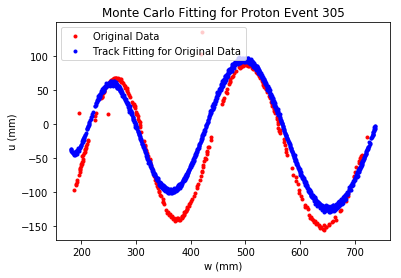

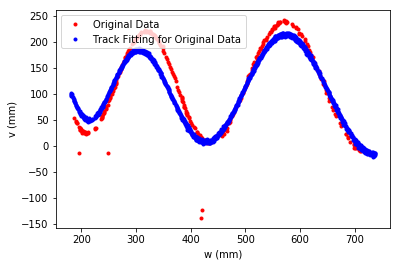

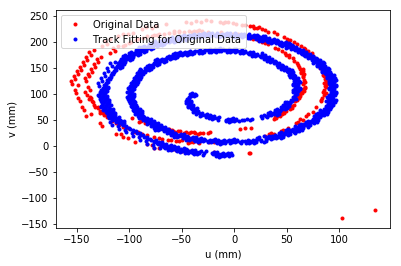

Text(0.5,0.92,'Simulated Data - Event 305')

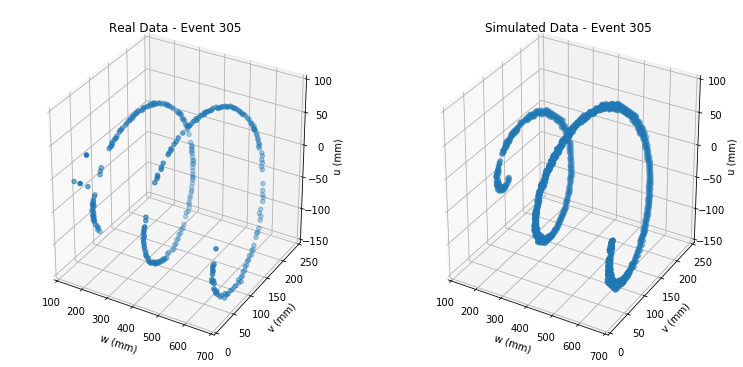

In [51]:
%matplotlib inline
#mcres = [-0.02969249,-0.009543,0.71451052,2.76331226,-3.20392047,1.91838566] #original function, event 305
mcres = [-0.00593864,-0.01684641,0.74081175,2.37207457,-3.1422649,2.00046055] #CC function, event 305
sim = EventSimulator(config)
padrotmat = rot_matrix(pad_rot_angle)

evtClean, ctr = sim.make_event(mcres[0], mcres[1], mcres[2], mcres[3], mcres[4], mcres[5])
pyevtClean = sim.convert_event(evtClean)

sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True,baseline_correction=True, cg_times=True)
sim_xy = sim_xyzs[:, 0:2]
sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
sim_uvw_values = sim_uvw.values

#uvw_values[:, 0], uvw_values[:, 1] = padrotmat @ uvw_values[:, :2].T
#sim_uvw_values[:, 0], sim_uvw_values[:, 1] = padrotmat @ sim_uvw_values[:, :2].T

plt.plot(uvw_values[:, 7], uvw_values[:, 5], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 5], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("u (mm)")

plt.title("Monte Carlo Fitting for Proton Event 305")
plt.legend(loc=2)
plt.show()

plt.plot(uvw_values[:, 7], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 7], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("w (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()

plt.plot(uvw_values[:, 5], uvw_values[:, 6], 'r.', label='Original Data')
plt.plot(sim_uvw_values[:, 5], sim_uvw_values[:, 6], 'b.', label='Track Fitting for Original Data')
plt.xlabel("u (mm)")
plt.ylabel("v (mm)")
plt.legend(loc=2)
plt.show()

from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure(figsize=(20, 14))

ax = fig.add_subplot(2, 3, 1, projection='3d') #2,3,1 meaning the plot will take the 1st position on a grid with 2 rows and three columns
ax.scatter(uvw_values[:,7],uvw_values[:,6],uvw_values[:,5])
ax.set_xlabel('w (mm)')
ax.set_ylabel('v (mm)')
ax.set_zlabel('u (mm)')
ax.set_xlim(100,700)
ax.set_ylim(0,250)
ax.set_zlim(-150,100)
ax.set_title('Real Data - Event 305')

ax2 = fig.add_subplot(2, 3, 2, projection='3d')
ax2.scatter(sim_uvw_values[:,7],sim_uvw_values[:,6],sim_uvw_values[:,5])
ax2.set_xlabel('w (mm)')
ax2.set_ylabel('v (mm)')
ax2.set_zlabel('u (mm)')
ax2.set_xlim(100,700)
ax2.set_ylim(0,250)
ax2.set_zlim(-150,100)
ax2.set_title('Simulated Data - Event 305')

In [ ]:
min_chi_value = []
min_chi_list = [sigma_init]
# set original candidate to be the seed point
candidate = ctr0

for i in range(num_iters): ### number of iteration equals 20
    
    # search space gets narrower within each iteration
    sigma = sigma_init*red_factor**float(i)
    
    # generate a set of parameter vectors within given range
    x = np.random.uniform(low=candidate[0]-sigma[0], high=candidate[0]+sigma[0], size=1000)
    y = np.random.uniform(low=candidate[1]-sigma[1], high=candidate[1]+sigma[1], size=1000)
    z = np.random.uniform(low=candidate[2]-sigma[2], high=candidate[2]+sigma[2], size=1000)
    # set min energy equal to zero
    if candidate[3]-sigma[3] >= 0.0:
        e = np.random.uniform(low=candidate[3]-sigma[3], high=candidate[3]+sigma[3], size=1000)
    else:
        e = np.random.uniform(low=0.0, high=candidate[3]+sigma[3], size=1000)
    a = np.random.uniform(low=candidate[4]-sigma[4], high=candidate[4]+sigma[4], size=1000)
    p = np.random.uniform(low=candidate[5]-sigma[5], high=candidate[5]+sigma[5], size=1000)
    candidates = np.stack((x,y,z,e,a,p),axis=-1)
    
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    sigmaPos = 5.0
    sigmaEng = 0.1
    
    count = 0
    num = 0

    while num-count <= num_pts-1.0: # make sure each iteration 500 candidates are generated

        chi2Pos_x = np.empty((0,0))
        chi2Pos_y = np.empty((0,0))
        
        try:
            evtClean, ctr = sim.make_event(candidates[num][0], candidates[num][1], candidates[num][2],\
                                   candidates[num][3], candidates[num][4], candidates[num][5])
        except Exception:
            count += 1
            num += 1
            continue

        #transform simulated data into uvw coordinates
        pyevtClean = sim.convert_event(evtClean)
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
        sim_xy = sim_xyzs[:, 0:2]
        sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
        sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
        sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
        sim_uvw_values = sim_uvw.values

        ##### find energy chi2 #####
        hits = np.zeros(10240)
        for k, v in evtClean.items():
            hits[k] += v.max()
        
        sigmaEn = np.nanmax(exp_hits)*sigmaEng
        
        for p in range(10240):        
            if exp_hits[p] != 0:
                if exp_hits[p] >= 5.0 and hits[p] >= 5.0:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(exp_hits[int(p)])
                    hit_num += 1.0
                else:
                    chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(sigmaEn**2)
                    hit_num += 1.0

        EngChi2 = np.append(EngChi2,chi2En_per_evt/hit_num)

        ##### find vertex chi2 #####
        Chi2Vert_per_evt = (candidates[num][0]**2 + candidates[num][1]**2)/sigmaVert
        VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

        ##### find position chi2 #####
        f_x = interpolate.interp1d(sim_uvw_values[:,7],sim_uvw_values[:,5],bounds_error=False)
        f_y = interpolate.interp1d(sim_uvw_values[:,7],sim_uvw_values[:,6],bounds_error=False)

        sim_x = f_x(uvw_values[:,7])
        sim_y = f_y(uvw_values[:,7])

        col_mean_x = np.nanmean(sim_x)
        inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
        sim_x[inds_x] = 0.0

        col_mean_y = np.nanmean(sim_y)
        inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
        sim_y[inds_y] = 0.0
        
        for i in range(len(uvw_values)):
            if abs(sim_x[i]) >= 5.0 and abs(sim_y[i]) >= 5.0:
                if abs(uvw_values[i,5]) >= 5.0 and abs(uvw_values[i,6]) >= 5.0:
                    Poschi2_per_evt = np.append(Poschi2_per_evt, (uvw_values[i,5]-sim_x[i])**2/abs(uvw_values[i,5])+(uvw_values[i,6]-sim_y[i])**2/abs(uvw_values[i,6]))
                elif abs(sim_x[i]) >= 5.0 and abs(uvw_values[i,5]) >= 5.0:
                    Poschi2_per_evt = np.append(Poschi2_per_evt, (uvw_values[i,5]-sim_x[i])**2/abs(uvw_values[i,5]) +(uvw_values[i,6]-sim_y[i])**2/sigmaPos**2)
                elif abs(sim_y[i]) >= 5.0 and abs(uvw_values[i,6]) >= 5.0:
                    Poschi2_per_evt = np.append(Poschi2_per_evt, (uvw_values[i,5]-sim_x[i])**2/sigmaPos**2 +(uvw_values[i,6]-sim_y[i])**2/abs(uvw_values[i,6]))
            else:
                Poschi2_per_evt = np.append(Poschi2_per_evt, (uvw_values[i,5]-sim_x[i])**2/sigmaPos**2 +(uvw_values[i,6]-sim_y[i])**2/sigmaPos**2)


        try:
            Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0)
        except Exception:
            Poschi2 = np.append(Poschi2, 1e3)
        
        
        Poschi2_per_evt = np.empty((0,0))
        chi2En_per_evt = 0.0
        Chi2Vert_per_evt = 0.0
        hit_num = 0.0
        
        num += 1

    min_chi = min(Poschi2+EngChi2+VertChi2)
    print('minimum chi2:' + str(min_chi))
    min_chi_value.append(min_chi)
    print(len(Poschi2))
    for i in range(len(Poschi2)):
        if abs(Poschi2[i]+EngChi2[i]+VertChi2[i]-min_chi) < 1e-5:
            candidate = candidates[i]
            min_chi_list = np.append(min_chi_list,[candidate],axis=0)
            print(min_chi_list)
            print(min_chi_value)
            print(Poschi2[i])
            print(EngChi2[i])
            print(VertChi2[i])

print(min_chi_value)
print(min_chi_list)
min_chi_list = np.delete(min_chi_list,0,0)
for i in range(len(min_chi_value)):
    if abs(min_chi_value[i]-min(min_chi_value)) < 1e-5:
        print(min_chi_list[i])

/home/chen/anaconda3/lib/python3.6/site-packages/pytpc-1.1.0-py3.6-linux-x86_64.egg/pytpc/evtdata.py:187: RuntimeWarning: invalid value encountered in true_divide
  return np.sum(peak_data * range_idx, axis=-1) / peak_data.sum(axis=-1)
/home/chen/anaconda3/lib/python3.6/site-packages/scipy/interpolate/interpolate.py:689: RuntimeWarning: invalid value encountered in greater
  above_bounds = x_new > self.x[-1]
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:89: RuntimeWarning: Mean of empty slice
/home/chen/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:93: RuntimeWarning: Mean of empty slice


In [ ]:
# original objective function for differential evolution method
# in progress

def fit(x):

    sigmaPos = 5.0 ### in mm
    Poschi2 = np.empty((0,0))
    Poschi2_per_evt = np.empty((0,0))
    sigmaEng = 0.1
    sim = EventSimulator(config)
    chi2En_per_evt = 0.0
    hit_num = 0.0
    EngChi2 = np.empty((0,0))
    sigmaVert = 0.5e-4
    Chi2Vert_per_evt = 0.0
    VertChi2 = np.empty((0,0))
    
    count = 0
    num = 0
        

    chi2Pos_x = np.empty((0,0))
    chi2Pos_y = np.empty((0,0))

    evtClean, ctr = sim.make_event(x[0], x[1], x[2],\
                                       x[3], x[4], x[5])

    pyevtClean = sim.convert_event(evtClean)
    
    try:
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    except Exception:
        return 500.0
    
    sim_xy = sim_xyzs[:, 0:2]
    sim_xy_C = np.ascontiguousarray(sim_xy, dtype=np.double)
    sim_cx, sim_cy = pytpc.cleaning.hough_circle(sim_xy_C)
    sim_uvw, (sim_cu, sim_cv) = mcfitter.preprocess(sim_xyzs[:, 0:5], center=(sim_cx, sim_cy), rotate_pads=True)
    sim_uvw_values = sim_uvw.values

    ##### find energy chi2 #####

    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()

    sigmaEn = np.nanmax(exp_hits)*sigmaEng

    for p in range(10240):        
        if exp_hits[p] != 0:
            if np.isnan(exp_hits[p]) == False:
                chi2En_per_evt += (float(exp_hits[int(p)])-float(hits[int(p)]))**2
                hit_num += 1.0

    EngChi2 = np.append(EngChi2,chi2En_per_evt/sigmaEn**2/hit_num)

    ##### find Vertex chi2 #####

    Chi2Vert_per_evt = (x[0]**2 + x[1]**2)/sigmaVert
    VertChi2 = np.append(VertChi2,Chi2Vert_per_evt)

    ##### find position chi2 #####

    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x))
    sim_x[inds_x] = 0.0

    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y))
    sim_y[inds_y] = 0.0

    chi2Pos_x = np.append(chi2Pos_x,(sim_x-xyzs[:,0])/float(sigmaPos))    
    chi2Pos_y = np.append(chi2Pos_y,(sim_y-xyzs[:,1])/float(sigmaPos)) 

    Poschi2 = np.append(Poschi2,sum(chi2Pos_y**2+chi2Pos_x**2)/float(len(xyzs)))

        
    min_chi = min(Poschi2+EngChi2+VertChi2)
    return min_chi


In [ ]:
def fit(x):
    
    Poschi2 = 0.0
    Poschi2_per_evt = np.empty((0,0))
    sim = EventSimulator(config)
    hit_num = 0.0
    EngChi2 = 0.0
    sigmaVert = 0.5e-2
    VertChi2 = 0.0
    sigmaPos = 5.0
    sigmaEng = 0.1

    chi2Pos_x = np.empty((0,0))
    chi2Pos_y = np.empty((0,0))
    
    evtClean, ctr = sim.make_event(x[0], x[1], x[2],\
                                   x[3], x[4], x[5])

    pyevtClean = sim.convert_event(evtClean)
    try:
        sim_xyzs = pyevtClean.xyzs(peaks_only=True, return_pads=True, baseline_correction=True, cg_times=True)
    except Exception:
        return 500.0

        ##### find energy chi2 #####
    hits = np.zeros(10240)
    for k, v in evtClean.items():
        hits[k] += v.max()
        
    sigmaEn = np.nanmax(exp_hits)*sigmaEng
        
    for p in range(10240):        
        if exp_hits[p] != 0:
            if exp_hits[p] >= 5.0 and hits[p] >= 5.0:
                EngChi2 += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(exp_hits[int(p)])
                hit_num += 1.0
            else:
                EngChi2 += (float(exp_hits[int(p)])-float(hits[int(p)]))**2/float(sigmaEn**2)
                hit_num += 1.0

    EngChi2 = EngChi2/hit_num

    ##### find vertex chi2 #####
    VertChi2 = (x[0]**2 + x[1]**2)/sigmaVert

    ##### find position chi2 #####
    f_x = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,0],bounds_error=False)
    f_y = interpolate.interp1d(sim_xyzs[:,2],sim_xyzs[:,1],bounds_error=False)

    sim_x = f_x(xyzs[:,2])
    sim_y = f_y(xyzs[:,2])

    col_mean_x = np.nanmean(sim_x)
    inds_x = np.where(np.isnan(sim_x)) #array with all the indicies that have a Nan
    sim_x[inds_x] = 0.0

    col_mean_y = np.nanmean(sim_y)
    inds_y = np.where(np.isnan(sim_y)) #array with all the indicies that have a Nan
    sim_y[inds_y] = 0.0
        
    for i in range(len(xyzs)):
        if abs(sim_x[i]) >= 5.0 and abs(sim_y[i]) >= 5.0:
            if abs(xyzs[i,0]) >= 5.0 and abs(xyzs[i,1]) >= 5.0:
                Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/abs(xyzs[i,0])+(xyzs[i,0]-sim_y[i])**2/abs(xyzs[i,1]))
        elif abs(sim_x[i]) >= 5.0 and abs(xyzs[i,0]) >= 5.0:
            Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/abs(xyzs[i,0]) +(xyzs[i,0]-sim_y[i])**2/sigmaPos**2)
        elif abs(sim_y[i]) >= 5.0 and abs(xyzs[i,1]) >= 5.0:
            Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/sigmaPos**2 +(xyzs[i,0]-sim_y[i])**2/abs(xyzs[i,1]))
        else:
            Poschi2_per_evt = np.append(Poschi2_per_evt, (xyzs[i,0]-sim_x[i])**2/sigmaPos**2 +(xyzs[i,0]-sim_y[i])**2/sigmaPos**2)

    Poschi2 = sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0
        
    min_chi = Poschi2+EngChi2+VertChi2
    return min_chi


In [ ]:
j = 1
def callbackF(x,convergence=0.5):
    global j
    print(str(j)+' '+str(x[0])+' '+str(x[1])+' '+str(x[2])+' '+str(x[3])+' '+str(x[4])+' '+str(x[5])+' '+str(f(x)))
    j += 1
bounds = [(-0.1,0.1), (-0.1, 0.1), (0, 1), (0,5), (-2 * pi, 0), (0, pi)]
results = scipy.optimize.differential_evolution(fit, bounds, callback=callbackF, maxiter=2, strategy='best1bin',\
                                                recombination=0.7, popsize=15, mutation=(0.5,1.0),polish=True)

In [ ]:
results.x

In [ ]:
#i = 1
#def callbackF(x, f, accept):
#    print(str(f))

scipy.optimize.basinhopping(f,ctr0, niter=2, T=0.01, stepsize=0.02, minimizer_kwargs={"method": "SLSQP"})

In [ ]:
x = np.array([1,2,3])
y = np.array([1,1,1])
z = 1.0-x/y
print(z**2)

In [ ]:

    sigma = sigma_init*reduction_factor**float(i)
    num_events = 100
    candidates = [sigma]
    print(candidate)
    while len(candidates) <= 501.0:
        pgen = uniform_param_generator(beam_enu0, beam_mass, beam_charge, mass_num, max_beam_angle,\
                                   beam_origin_z, gas, num_events)
        for evt in pgen:
            p = evt[0]
            try:
                if abs(p[0]-candidate[0]) >= sigma[0]:
                    raise ValueError
                elif abs(p[1]-candidate[1]) >= sigma[1]:
                    raise ValueError
                elif abs(p[2]-candidate[2]) >= sigma[2]:
                    raise ValueError
                elif abs(p[3]-candidate[3]) >= sigma[3]:
                    raise ValueError
                elif abs(p[4]-candidate[4]) >= sigma[4]:
                    raise ValueError
                elif abs(p[5]-candidate[5]) >= sigma[5]:
                    raise ValueError
            except ValueError:
                continue
            candidates = np.append(candidates, [p], axis=0)
    candidates = np.delete(candidates,0,0)
    
#        for i in range(len(xyzs)):
#            if np.isnan(sim_x[i]) == False:
#                if np.isnan(sim_y[i]) == False:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i]/xyzs[i,0])**2+(1.0-sim_y[i]/xyzs[i,1])**2)
#        try:
#            Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(Poschi2_per_evt))/2.0)
#        except Exception:
#            Poschi2 = np.append(Poschi2, 1e3)

#        for i in range(len(xyzs)):
#            if abs(sim_x[i]/xyzs[i,0]) <= 1.0:
#                if abs(sim_y[i]/xyzs[i,1]) <= 1.0:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i])**2/abs(xyzs[i,0])+\
#                                                                    (1.0-sim_y[i])**2/abs(xyzs[i,1]))
#                else:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-sim_x[i])**2/abs(xyzs[i,0])+\
#                                                                    (1.0-xyzs[i,1])**2/abs(sim_y[i]))
#            else:
#                if abs(sim_y[i]/xyzs[i,1]) <= 1.0:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-xyzs[i,0])**2/abs(sim_x[i])+\
#                                                                    (1.0-sim_y[i])**2/abs(xyzs[i,1]))
#                else:
#                    Poschi2_per_evt = np.append(Poschi2_per_evt, (1.0-xyzs[i,0])**2/abs(sim_x[i])+\
#                                                                    (1.0-xyzs[i,1])**2/abs(sim_y[i]))

#        Poschi2 = np.append(Poschi2, sum(Poschi2_per_evt)/float(len(xyzs))/2.0)